# Stock market prediction and foreacasting using Stacked LSTM

**Data Collection**

In [1]:
import pandas_datareader as pdr

key = "d063851ad4d2597e3e9cf1eb463730597b79faa6"

In [2]:
pip install --upgrade pandas_datareader


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import requests

# Tiingo API Key and URL
url = f'https://api.tiingo.com/tiingo/daily/AAPL/prices?token={key}'

# Fetch the data
response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data)
print(df.head())


   adjClose  adjHigh  adjLow  adjOpen  adjVolume   close  \
0    227.55   229.41  227.34    229.3   31759188  227.55   

                        date  divCash    high     low   open  splitFactor  \
0  2024-10-11T00:00:00+00:00      0.0  229.41  227.34  229.3          1.0   

     volume  
0  31759188  


In [4]:
df.to_csv("AAPL.csv")

In [5]:
df1 = pd.read_csv("/kaggle/input/apple-stock-data-updated-till-22jun2021/AAPL.csv")
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [6]:
df1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10404,2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200
10405,2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400
10406,2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000
10407,2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700
10408,2022-03-24,171.059998,174.139999,170.210007,174.070007,174.070007,90018700


In [7]:
df2 = df1.reset_index()["Close"]
df2.shape

(10409,)

In [8]:
print(df2)

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10404    163.979996
10405    165.380005
10406    168.820007
10407    170.210007
10408    174.070007
Name: Close, Length: 10409, dtype: float64


In [9]:
df3 =df2.copy()

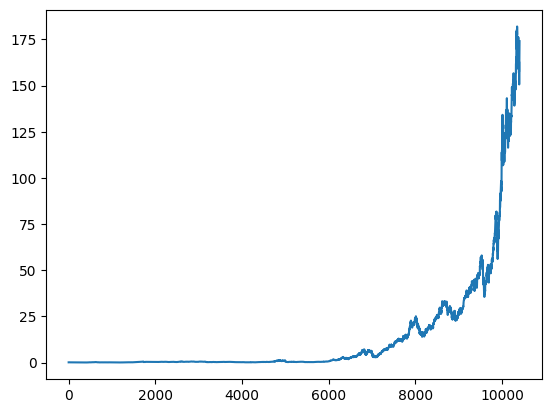

In [10]:
import matplotlib.pyplot as plt
plt.plot(df2)

# LSTM are sensitive to the scale of the data so we apply MinMax Scaler

In [11]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1, 1)) 

In [12]:
df2.shape

(10409, 1)

In [13]:
print(df2)

[[4.35483696e-04]
 [3.98684579e-04]
 [3.49613594e-04]
 ...
 [9.27511961e-01]
 [9.35150965e-01]
 [9.56364315e-01]]


# Train Test Split

In [14]:
# from sklearn.preprocessing import train_test_split

train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train_data, test_data = df2[0 : train_size, :], df2[train_size:len(df1),:1]

In [15]:
train_size, test_size

(8327, 2082)

In [16]:
print(train_data)

[[0.00043548]
 [0.00039868]
 [0.00034961]
 ...
 [0.10974984]
 [0.1085506 ]
 [0.10915316]]


# Data Preprocessing

In [17]:
# COnvert an array of values into a dataset matrix

def create_dataset(dataset, time_step = 1):

    dataX, dataY = [], []


    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # i = 0, 1, 2 , 3 ----------- 99      100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X = t, t+1, t+2, t+3 and Y = t+4

time_step = 100
X_train , y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train)

[[0.00043548 0.00039868 0.00034961 ... 0.00042322 0.00042015 0.00040175]
 [0.00039868 0.00034961 0.00036495 ... 0.00042015 0.00040175 0.00041095]
 [0.00034961 0.00036495 0.00038335 ... 0.00040175 0.00041095 0.00041708]
 ...
 [0.08340391 0.08196719 0.08619101 ... 0.10964777 0.1109059  0.11073318]
 [0.08196719 0.08619101 0.0857965  ... 0.1109059  0.11073318 0.10991078]
 [0.08619101 0.0857965  0.08628522 ... 0.11073318 0.10991078 0.10974984]]


In [20]:
print(y_train)

[0.00041095 0.00041708 0.00040175 ... 0.10991078 0.10974984 0.1085506 ]


In [21]:
print(X_train.shape), print(y_train.shape)

(8226, 100)
(8226,)


(None, None)

# Create Stacked LSTM model

In [22]:
# Reshape input to be [samples, time steps, features] which is requred for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
X_train.shape, X_test.shape

((8226, 100, 1), (1981, 100, 1))

In [24]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape =(100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.3063e-04 - val_loss: 0.0016
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.7832e-06 - val_loss: 0.0023
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0963e-06 - val_loss: 0.0020
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.5859e-06 - val_loss: 0.0045
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.0901e-06 - val_loss: 0.0046
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.7911e-06 - val_loss: 0.0034
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.9742e-06 - val_loss: 0.0017
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.7432e-06 - val_loss: 0.0047
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8492e-06 - val_loss: 0.0032
Epoch 10/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.6582e-06 - val_loss: 0.0014
Epoch 11/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.3864e-06 - val

# Predict the test data and plot the output

In [29]:
# do predictions and check performance metrices

train_predict = model.predict(X_train)
test_predict =  model.predict(X_test)

258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [30]:
# Transformback to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [31]:
print(train_predict)

[[ 0.14353818]
 [ 0.14390439]
 [ 0.14531162]
 ...
 [20.08015   ]
 [19.977436  ]
 [19.919922  ]]


In [32]:
#  Calculate RMSE performance metrics

import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train, train_predict))

5.602268929050333

In [33]:
# test Data RMSE

math.sqrt(mean_squared_error(y_test, test_predict))

69.95199116737858

In [34]:
df2

array([[4.35483696e-04],
       [3.98684579e-04],
       [3.49613594e-04],
       ...,
       [9.27511961e-01],
       [9.35150965e-01],
       [9.56364315e-01]])

# Plotting the datas

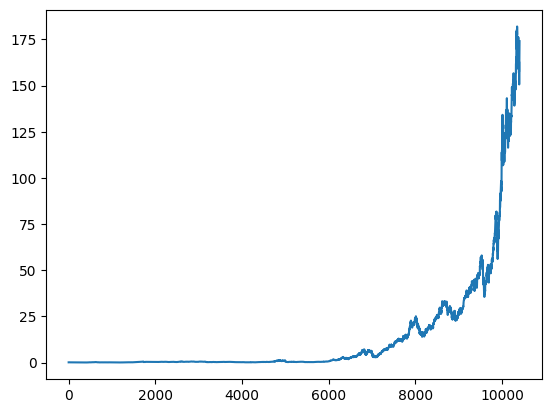

In [35]:
# Assuming df2 contains scaled data of multiple columns and we scaled only the 'Price' column
df2_scaled = df2  # Or the relevant part of df2 that was scaled

# Inverse transform only the scaled columns (adjust based on your specific columns)
df2_inverse_transformed = scaler.inverse_transform(df2_scaled)

# Plot the inverse transformed actual data
plt.plot(df2_inverse_transformed, label='Actual Data')


In [36]:
df3 = df1.reset_index()["Close"]
print(df3)

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10404    163.979996
10405    165.380005
10406    168.820007
10407    170.210007
10408    174.070007
Name: Close, Length: 10409, dtype: float64


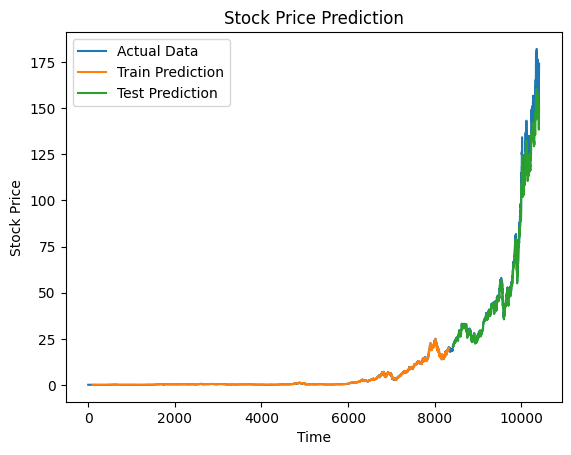

In [37]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df2) - 1, :] = test_predict

# Plot the baseline & predictions
plt.plot(df3, label='Actual Data')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')

# Add title and labels
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')

# Add legend
plt.legend()

# Show plot
plt.show()


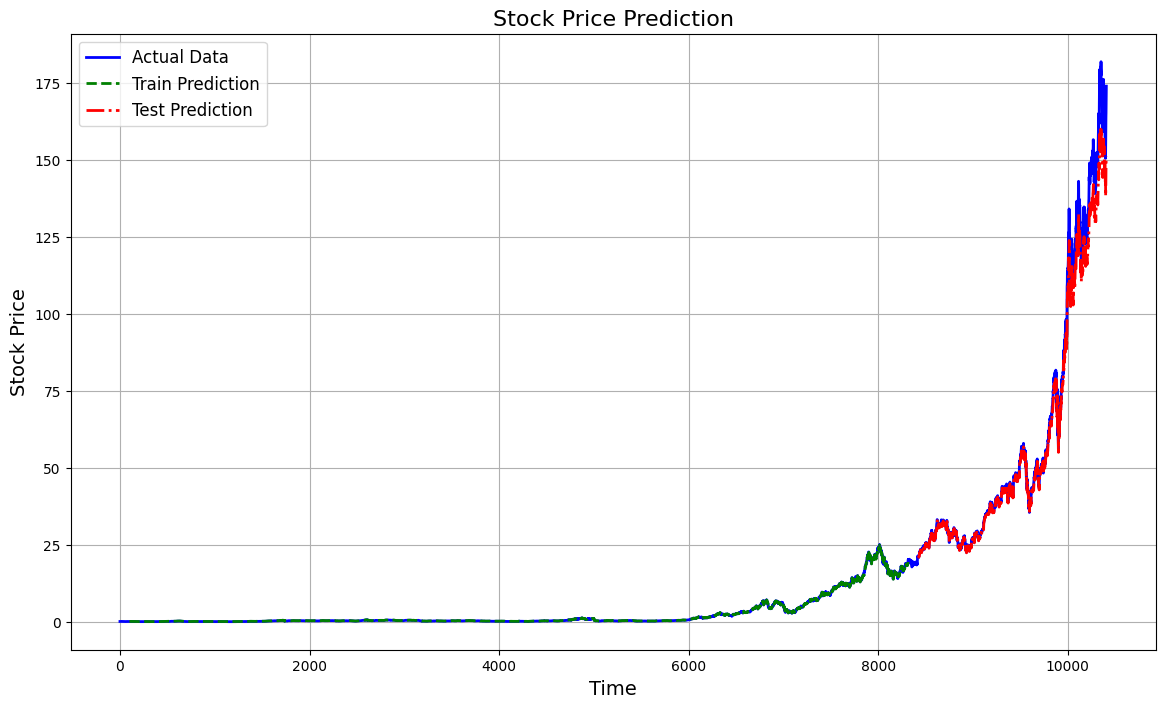

In [38]:
import matplotlib.pyplot as plt

look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df2) - 1, :] = test_predict

# Create a larger figure
plt.figure(figsize=(14, 8))  # Width: 14 inches, Height: 8 inches

# Plot the baseline (Actual Data) and predictions
plt.plot(df3, label='Actual Data', color='blue', linewidth=2)  # Thicker line for actual data
plt.plot(trainPredictPlot, label='Train Prediction', color='green', linestyle='--', linewidth=2)  # Dashed line for training predictions
plt.plot(testPredictPlot, label='Test Prediction', color='red', linestyle='-.', linewidth=2)  # Dash-dot line for test predictions

# Add title and labels
plt.title('Stock Price Prediction', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)

# Add grid for better visibility
plt.grid(True)

# Add legend with larger font size
plt.legend(fontsize=12)

# Show plot
plt.show()


# Predict stock price for next 30 days

In [39]:
len(test_data)

2082

**For predicting new data we need to consider and take into account for previous 100 days data**

In [40]:
print(test_data[1982])

[0.81836763]


In [41]:
x_input = test_data[1982:].reshape(1, -1)
x_input.shape

(1, 100)

In [42]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
print(temp_input)

[0.8183676263439645, 0.8241930375718983, 0.8322717022572454, 0.8293589993911218, 0.8311175751131749, 0.8265012149204283, 0.8285345969514063, 0.8126520628982641, 0.8123772620850255, 0.8240281724718774, 0.8240831018586807, 0.8295787883822593, 0.8432630753044027, 0.8673341273208118, 0.8820626111694948, 0.8846455893312632, 0.8867889070754589, 0.8897016099415825, 0.8615087160928782, 0.8803589593385585, 0.9081671221564932, 0.9052544137946831, 0.89970372094469, 0.8891520083151055, 0.9082770578697109, 0.9404817039582704, 0.9619149308614057, 0.9590571518863987, 0.9859310534910116, 0.9655421004540271, 0.9577931659687218, 0.985106733486594, 0.9464170563951083, 0.9402619094714463, 0.9326229106993585, 0.950428962514186, 0.9649924988275501, 0.9685097382026405, 0.9907672851101935, 0.9850517216644931, 0.9855463993998534, 0.9790614453365384, 0.9755992177835491, 0.9999999999999999, 0.9873049751219063, 0.961035599034887, 0.9449882053774105, 0.9459224610950457, 0.9460323968082635, 0.9619149308614057, 0.96

In [43]:
print(temp_input[1:])

[0.8241930375718983, 0.8322717022572454, 0.8293589993911218, 0.8311175751131749, 0.8265012149204283, 0.8285345969514063, 0.8126520628982641, 0.8123772620850255, 0.8240281724718774, 0.8240831018586807, 0.8295787883822593, 0.8432630753044027, 0.8673341273208118, 0.8820626111694948, 0.8846455893312632, 0.8867889070754589, 0.8897016099415825, 0.8615087160928782, 0.8803589593385585, 0.9081671221564932, 0.9052544137946831, 0.89970372094469, 0.8891520083151055, 0.9082770578697109, 0.9404817039582704, 0.9619149308614057, 0.9590571518863987, 0.9859310534910116, 0.9655421004540271, 0.9577931659687218, 0.985106733486594, 0.9464170563951083, 0.9402619094714463, 0.9326229106993585, 0.950428962514186, 0.9649924988275501, 0.9685097382026405, 0.9907672851101935, 0.9850517216644931, 0.9855463993998534, 0.9790614453365384, 0.9755992177835491, 0.9999999999999999, 0.9873049751219063, 0.961035599034887, 0.9449882053774105, 0.9459224610950457, 0.9460323968082635, 0.9619149308614057, 0.9643879733099565, 0.94

In [44]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print("------------------------------------------------------------------------------")
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.8519731]
101
1 day input [0.82419304 0.8322717  0.829359   0.83111758 0.82650121 0.8285346
 0.81265206 0.81237726 0.82402817 0.8240831  0.82957879 0.84326308
 0.86733413 0.88206261 0.88464559 0.88678891 0.88970161 0.86150872
 0.88035896 0.90816712 0.90525441 0.89970372 0.88915201 0.90827706
 0.9404817  0.96191493 0.95905715 0.98593105 0.9655421  0.95779317
 0.98510673 0.94641706 0.94026191 0.93262291 0.95042896 0.9649925
 0.96850974 0.99076729 0.98505172 0.9855464  0.97906145 0.97559922
 1.         0.98730498 0.9610356  0.94498821 0.94592246 0.9460324
 0.96191493 0.96438797 0.9460324  0.95086863 0.93289771 0.91327807
 0.90382549 0.89228459 0.88794295 0.87783091 0.87733632 0.87475334
 0.93581042 0.96026621 0.95933195 0.96609162 0.94993429 0.94713152
 0.94311969 0.96054101 0.96850974 0.94564766 0.92652269 0.92784169
 0.94932976 0.94801085 0.92784169 0.9191585  0.90278137 0.8794247
 0.89409818 0.90569408 0.90717785 0.89662615 0.91509166 0.91327807
 0.89646128 0.875193   0.86497102 0.89

In [55]:

print(lst_output)

[[0.8519731163978577], [0.7995161414146423], [0.7413646578788757], [0.6880991458892822], [0.6416268348693848], [0.6023832559585571], [0.569913387298584], [0.5431713461875916], [0.5208585858345032], [0.5017058849334717], [0.4846585690975189], [0.46895721554756165], [0.4541371166706085], [0.4399759769439697], [0.42642009258270264], [0.413511723279953], [0.4013277292251587], [0.38993772864341736], [0.3793805241584778], [0.36965519189834595], [0.36072438955307007], [0.3525233268737793], [0.34497174620628357], [0.33798468112945557], [0.3314816951751709], [0.3253917396068573], [0.3196561932563782], [0.31422874331474304], [0.30907386541366577], [0.30416449904441833]]


In [46]:
day_new = np.arange(1, 101)
day_predict = np.arange(101, 131)

In [47]:
len(df2)

10409

In [48]:
df4 = df2.tolist()
df4.extend(lst_output)

In [49]:
# plt.plot(day_new,scaler.inverse_transform(df1[10309:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [50]:
print(df3)

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10404    163.979996
10405    165.380005
10406    168.820007
10407    170.210007
10408    174.070007
Name: Close, Length: 10409, dtype: float64


In [51]:
print(lst_output)

[[0.8519731163978577], [0.7995161414146423], [0.7413646578788757], [0.6880991458892822], [0.6416268348693848], [0.6023832559585571], [0.569913387298584], [0.5431713461875916], [0.5208585858345032], [0.5017058849334717], [0.4846585690975189], [0.46895721554756165], [0.4541371166706085], [0.4399759769439697], [0.42642009258270264], [0.413511723279953], [0.4013277292251587], [0.38993772864341736], [0.3793805241584778], [0.36965519189834595], [0.36072438955307007], [0.3525233268737793], [0.34497174620628357], [0.33798468112945557], [0.3314816951751709], [0.3253917396068573], [0.3196561932563782], [0.31422874331474304], [0.30907386541366577], [0.30416449904441833]]


In [52]:
len(df3)

10409

In [53]:
print(test_data)

[[0.10866052]
 [0.10783224]
 [0.10659375]
 ...
 [0.92751196]
 [0.93515096]
 [0.95636431]]


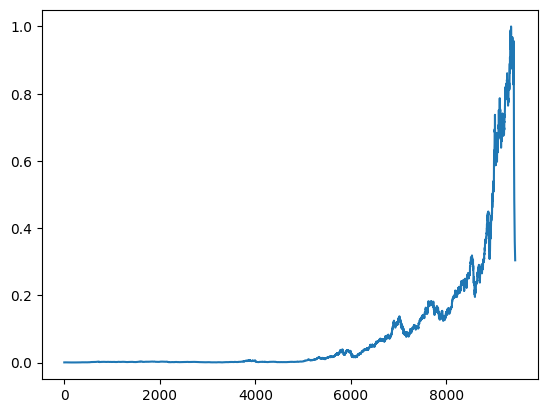

In [57]:
df4 = df2.tolist()
df4.extend(lst_output)
plt.plot(df4[1000:])